In [18]:
require 'dp'
require 'save_report'
require 'insects'

In [2]:
--[[hyperparameters]]--
opt = {
   learningRate = 0.7, --training learning rate at beginning
   lrDecay = 'none', -- type of learning rate decay : adaptive | linear | schedule | none
   minLR = 0.0001, -- minimum learning rate
   saturateEpoch = 300, -- epoch at which linear decayed LR will reach minLR
   maxWait = 4, -- aximum number of epochs to wait for a new minima to be found. After that, the learning rate is decayed by decayFactor
   decayFactor = 0.001, --factor by which learning rate is decayed for adaptive decay 
   maxOutNorm = 1, --maximum norm allowed for output neuron weights
   momentum = 0.5, --momentum factor to use for training
   batchSize = 128, --number of examples per mini-batch
   maxTries = 50, --maximum number of epochs without reduction in validation error.
   maxEpoch = 20, --maximum number of epochs of training
   activation = 'ReLU', -- activation function
   kernelStride = {1, 1, 1}, -- kernel stride of each convolution layer. Height = Width
   channelSize = {32, 64, 128}, -- nb of filters for each conv layer
   padding = {0, 0, 0}, -- order padding to add to the input before performing the convolution
   kernelSize = {5, 5, 5}, -- size of the filters (filters are squares) for each conv layer
   kernelStride = {1, 1, 1}, -- stride of the filters in each conv layer 
   poolSize = {2, 2, 2},  -- size of the max pooling of each convolution layer. Height = Width
   poolStride= {2, 2, 2}, -- stride of the max pooling of each convolution layer. Height = Width
   hiddenSize  = {400, 400}, -- size of fully connected layers
   cuda = true,
   useDevice = 2,
   dropoutProb  = {0, 0, 0, 0.5, 0.5}, -- dropout probability of each layer
   dropout = true,
   standardize = true,
   zca = true, 
   batchNorm = false, -- use batch normalization. dropout is mostly redundant with this')
   lecunlcn = false,
   model = 'dense', -- 'cnn' or 'dense'
   visualize_dataset = true,
   weight_decay_factor = 0.
}


In [3]:
datasource = dp.Insects({inputs="insects_train_images.t7", labels="insects_train_labels"})

In [4]:
--[[Visualize data]]--

if opt.visualize_dataset then
    train_set = (datasource._train_set._inputs._input)
    nb = train_set:size()[1]
    h = train_set:size()[3]
    w = train_set:size()[4]
    channels = train_set:size()[2]
    train_set = torch.reshape(train_set, nb, channels, h, w)
    targets  = datasource._train_set._targets._input
    
    r = {{1, 256}}
    train_set = train_set[r]
    targets = targets[r]
    
    
    -- visualize class Cls
    vis = {}
    for cls = 1, #datasource._str_classes do
        y = torch.eq(targets, cls)
        indices = torch.linspace(1,targets:size(1),targets:size(1)):long()
        selected = indices[y:eq(1)]
        train_set_selected = train_set:index(1,selected)
        vis[cls] = train_set_selected
    end
end

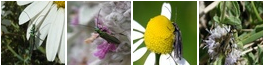

In [5]:
cls = 5
itorch.image(vis[cls])

In [6]:
local input_preprocess = {}
if opt.standardize then
   table.insert(input_preprocess, dp.Standardize())
end
if opt.zca then
   table.insert(input_preprocess, dp.ZCA())
end
if opt.lecunlcn then
   table.insert(input_preprocess, dp.GCN())
   table.insert(input_preprocess, dp.LeCunLCN{progress=false})
end


In [7]:
ds = dp.Insects{input_preprocess = input_preprocess, inputs="insects_train_images.t7", 
                labels="insects_train_labels"}

In [13]:
if opt.model == 'dense' then
    
    model = nn.Sequential()
    model:add(nn.Convert(ds:ioShapes(), 'bf')) -- to batchSize x nFeature (also type converts)

    -- hidden layers
    inputSize = ds:featureSize()
    for i,hiddenSize in ipairs(opt.hiddenSize) do
       model:add(nn.Linear(inputSize, hiddenSize)) -- parameters
       if opt.batchNorm then
          model:add(nn.BatchNormalization(hiddenSize))
       end
       model:add(nn[opt.activation]())
       if opt.dropout then
          model:add(nn.Dropout())
       end
       inputSize = hiddenSize
    end
    
    -- output layer
    model:add(nn.Linear(inputSize, #(ds:classes())))
    model:add(nn.LogSoftMax())
end

In [14]:
-- convolutional and pooling layers

if opt.model == "cnn" then
    
    cnn = nn.Sequential()
    depth = 3
    inputSize = ds:imageSize('c') or opt.loadSize[1]
    for i=1,#opt.channelSize do
       if opt.dropout and (opt.dropoutProb[depth] or 0) > 0 then
          -- dropout can be useful for regularization
          cnn:add(nn.SpatialDropout(opt.dropoutProb[depth]))
       end
       cnn:add(nn.SpatialConvolution(
          inputSize, opt.channelSize[i], 
          opt.kernelSize[i], opt.kernelSize[i], 
          opt.kernelStride[i], opt.kernelStride[i],
          opt.padding and math.floor(opt.kernelSize[i]/2) or 0
       ))
       if opt.batchNorm then
          -- batch normalization can be awesome
          cnn:add(nn.SpatialBatchNormalization(opt.channelSize[i]))
       end
       cnn:add(nn[opt.activation]())
       if opt.poolSize[i] and opt.poolSize[i] > 0 then
          cnn:add(nn.SpatialMaxPooling(
             opt.poolSize[i], opt.poolSize[i], 
             opt.poolStride[i] or opt.poolSize[i], 
             opt.poolStride[i] or opt.poolSize[i]
          ))
       end
       inputSize = opt.channelSize[i]
       depth = depth + 1
    end
    -- get output size of convolutional layers
    outsize = cnn:outside{1,ds:imageSize('c'),ds:imageSize('h'),ds:imageSize('w')}
    inputSize = outsize[2]*outsize[3]*outsize[4]
    dp.vprint(not opt.silent, "input to dense layers has: "..inputSize.." neurons")

    cnn:insert(nn.Convert(ds:ioShapes(), 'bchw'), 1)

    -- dense hidden layers
    cnn:add(nn.Collapse(3))
    for i,hiddenSize in ipairs(opt.hiddenSize) do
       if opt.dropout and (opt.dropoutProb[depth] or 0) > 0 then
          cnn:add(nn.Dropout(opt.dropoutProb[depth]))
       end
       cnn:add(nn.Linear(inputSize, hiddenSize))
       if opt.batchNorm then
          cnn:add(nn.BatchNormalization(hiddenSize))
       end
       cnn:add(nn[opt.activation]())
       inputSize = hiddenSize
       depth = depth + 1
    end

    -- output layer
    if opt.dropout and (opt.dropoutProb[depth] or 0) > 0 then
       cnn:add(nn.Dropout(opt.dropoutProb[depth]))
    end
    cnn:add(nn.Linear(inputSize, #(ds:classes())))
    cnn:add(nn.LogSoftMax())
    model = cnn
end

In [15]:
--[[Propagators]]--
if opt.lrDecay == 'adaptive' then
   ad = dp.AdaptiveDecay{max_wait = opt.maxWait, decay_factor=opt.decayFactor}
elseif opt.lrDecay == 'linear' then
   opt.decayFactor = (opt.minLR - opt.learningRate)/opt.saturateEpoch
end

train = dp.Optimizer{
   acc_update = opt.accUpdate,
   loss = nn.ModuleCriterion(nn.ClassNLLCriterion(), nil, nn.Convert()),
   epoch_callback = function(model, report) -- called every epoch
      if report.epoch > 0 then
         if opt.lrDecay == 'adaptive' then
            opt.learningRate = opt.learningRate*ad.decay
            ad.decay = 1
         elseif opt.lrDecay == 'schedule' and opt.schedule[report.epoch] then
            opt.learningRate = opt.schedule[report.epoch]
         elseif opt.lrDecay == 'linear' then 
            opt.learningRate = opt.learningRate + opt.decayFactor
         end
         opt.learningRate = math.max(opt.minLR, opt.learningRate)
         if not opt.silent then
            print("learningRate", opt.learningRate)
         end
      end
   end,
   callback = function(model, report) -- called every batch
      -- the ordering here is important
      if opt.accUpdate then
         model:accUpdateGradParameters(model.dpnn_input, model.output, opt.learningRate)
      else
         model:updateGradParameters(opt.momentum) -- affects gradParams
         model:updateParameters(opt.learningRate) -- affects params
      end
      model:maxParamNorm(opt.maxOutNorm) -- affects params
      model:zeroGradParameters() -- affects gradParams 
   end,
   feedback = dp.Confusion(),
   sampler = dp.ShuffleSampler{batch_size = opt.batchSize},
   progress = opt.progress
}
valid = ds:validSet() and dp.Evaluator{
   feedback = dp.Confusion(),  
   sampler = dp.Sampler{batch_size = opt.batchSize}
}
test = ds:testSet() and dp.Evaluator{
   feedback = dp.Confusion(),
   sampler = dp.Sampler{batch_size = opt.batchSize}
}

In [16]:
--[[Experiment]]--
xp = dp.Experiment{
   model = model,
   optimizer = train,
   validator = ds:validSet() and valid,
   tester = ds:testSet() and test,
   observer = {
      dp.FileLogger(),
      dp.EarlyStopper{
         error_report = {'validator','feedback','confusion','accuracy'},
         maximize = true,
         max_epochs = opt.maxTries
      }
   },
   random_seed = os.time(),
   max_epoch = opt.maxEpoch
}

--[[GPU or CPU]]--
if opt.cuda then
   require 'cutorch'
   require 'cunn'
   cutorch.setDevice(opt.useDevice)
   xp:cuda()
end

if not opt.silent then
   print"Model:"
   print(model)
end
xp:verbose(not opt.silent)

xp:run(ds)

Model:	
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> output]
  (1): nn.Convert
  (2): nn.Linear(12288 -> 400)
  (3): nn.ReLU
  (4): nn.Dropout(0.500000)
  (5): nn.Linear(400 -> 400)
  (6): nn.ReLU
  (7): nn.Dropout(0.500000)
  (8): nn.Linear(400 -> 18)
  (9): nn.LogSoftMax
}
{
  dpnn_serialType : false
  dpnn_serialEmpty : 
    {
      1 : output
      2 : gradInput
      3 : momGradParams
      4 : dpnn_input
    }
  gradInput : CudaTensor - empty
  modules : 
    {
      1 : 
        nn.Convert
        {
          dpnn_serialType : false
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          nInputDim : 4
          inputShape : bchw
          outputShape : bf
          outputBatchDim : 1
          inputBatchDim : 1
          dpnn_serialEmpty : 
            {
              1 : output
              2 : gradInput
              3 : momGradParams
              4 : dpnn_input
            }
          modules : t

            1 : output
              2 : gradInput
              3 : momGradParams
              4 : dpnn_input
            }
          gradWeight : CudaTensor - size: 400x12288
          output : CudaTensor - empty
        }
      3 : 
        nn.ReLU
        {
          inplace : false
          threshold : 0
          val : 0
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          dpnn_serialType : false
          dpnn_serialEmpty : 
            {
              1 : output
              2 : gradInput
              3 : momGradParams
              4 : dpnn_input
            }
        }
      4 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          noise : CudaTensor - empty
          train : true
          p : 0.5
          gradInput : CudaTensor - empty
          dpnn_serialType : false
          dpnn_serialEmpty : 
            {
              1 : output
              2 : gradInput
              3 : momGradParams
              4 : dpnn

  threshold : 0
          val : 0
          output : CudaTensor - empty
          gradInput : CudaTensor - empty
          dpnn_serialType : false
          dpnn_serialEmpty : 
            {
              1 : output
              2 : gradInput
              3 : momGradParams
              4 : dpnn_input
            }
        }
      7 : 
        nn.Dropout(0.500000)
        {
          v2 : true
          noise : CudaTensor - empty
          train : true
          p : 0.5
          gradInput : CudaTensor - empty
          dpnn_serialType : false
          dpnn_serialEmpty : 
            {
              1 : output
              2 : gradInput
              3 : momGradParams
              4 : dpnn_input
            }
          output : CudaTensor - empty
        }
      8 : 
        nn.Linear(400 -> 18)
        {
          gradBias : CudaTensor - size: 18
          weight : CudaTensor - size: 18x400
          dpnn_serialType : false
          bias : CudaTensor - size: 18
          gradInp

         dpnn_serialType : false
          output : CudaTensor - empty
        }
    }
  output : CudaTensor - empty
}


FileLogger: log will be written to /home/mcherti/save/romeo13:1444105143:1/log	


==> epoch # 1 for optimizer :	


==> example speed = 4386.1161808411 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.021536110823999	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.26420287006094	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 2 for optimizer :	
learningRate	0.7	


==> example speed = 7321.8263873566 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019413230084989	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28287792412031	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 3 for optimizer :	
learningRate	0.7	


==> example speed = 7648.8827042292 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.0193844801648	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28297621387851	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 4 for optimizer :	
learningRate	0.7	


==> example speed = 7673.5512838449 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019393335491073	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 5 for optimizer :	
learningRate	0.7	


==> example speed = 7638.3513245936 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019390043725849	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


SaveToFile: saving to /home/mcherti/save/romeo13:1444105143:1.dat	


==> epoch # 6 for optimizer :	
learningRate	0.7	


==> example speed = 7711.5123541312 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019393185465936	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 7 for optimizer :	
learningRate	0.7	


==> example speed = 7585.6652578927 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019370760316813	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 8 for optimizer :	
learningRate	0.7	


==> example speed = 7700.2896025061 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019373621058553	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 9 for optimizer :	
learningRate	0.7	


==> example speed = 7661.1799433035 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.01938767205387	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 10 for optimizer :	
learningRate	0.7	


==> example speed = 7677.0591605021 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.01937667304602	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 11 for optimizer :	
learningRate	0.7	


==> example speed = 7693.435684954 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019390969771357	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 12 for optimizer :	
learningRate	0.7	


==> example speed = 7543.6215479673 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019385853942307	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 13 for optimizer :	
learningRate	0.7	


==> example speed = 7685.8574347916 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019369723287387	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 14 for optimizer :	
learningRate	0.7	


==> example speed = 7684.8650134715 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019380928866868	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 15 for optimizer :	
learningRate	0.7	


==> example speed = 7644.2268078948 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019396326174923	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 16 for optimizer :	
learningRate	0.7	


==> example speed = 7718.064889273 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019381298657037	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	


romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 17 for optimizer :	
learningRate	0.7	


==> example speed = 7566.6472851434 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019378840630383	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 18 for optimizer :	


learningRate	0.7	


==> example speed = 7672.4972007234 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019384781386779	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 19 for optimizer :	
learningRate	0.7	


==> example speed = 7686.2242941601 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019368205155796	
romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	


==> epoch # 20 for optimizer :	
learningRate	

0.7	


==> example speed = 7653.6582108387 examples/s	


romeo13:1444105143:1:optimizer:loss avgErr 0.019386822684753	


romeo13:1444105143:1:optimizer:confusion accuracy = 0.28307450363672	
romeo13:1444105143:1:validator:confusion accuracy = 0.29742480833497	
romeo13:1444105143:1:tester:confusion accuracy = 0.2923137409082	
